<div class="title">Aplicaciones de Análisis &ndash; Predicción de Series Temporales: Energía Solar</div>
<div class="subtitle">Máster en Big Data y Data Science</div>
<div class="author">Ángela Fernández Pascual - Universidad Autónoma de Madrid</div>

A continuación se van a resumir los pasos a realizar para analizar y predecir una serie temporal, así como los paquetes y funciones necesarios para su ejecución en Python. 

**Configuración**

In [12]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

Los paquetes de Python necesarios para trabajar con series temporales son:

* **numpy**
* **pandas**
* **matplotlib**
* **statsmodels**
* **sklearn**

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
matplotlib.rc('figure', figsize=(15, 5))

from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsaplots

from os.path import isfile

import warnings
warnings.filterwarnings("ignore")

# Carpeta de salida
output_folder='./Output'

# Cargar los datos como serie temporal estacionaria

Vamos a cargar los datos originales de **Energía Solar** utilizados en el notebook de Análisis.

In [2]:
solar = pd.read_csv('solar.csv',
                    header=0, parse_dates=[0], index_col=[0], usecols=[0, 1], dayfirst=True, 
                    squeeze=True)

Recordemos el formato y las peculiaridades estadísiticas de este conjunto de datos.

In [3]:
solar.describe()

count    26304.000000
mean       159.245979
std        227.678783
min          0.000000
25%          0.000000
50%          0.000000
75%        297.302500
max        798.140000
Name: P, dtype: float64

In [4]:
solar.head()

time
2014-01-01 00:00:00    0.0
2014-01-01 01:00:00    0.0
2014-01-01 02:00:00    0.0
2014-01-01 03:00:00    0.0
2014-01-01 04:00:00    0.0
Name: P, dtype: float64

# Predicción utilizando Modelos Clásicos

## División en conjuntos de entrenamiento y predicción

Como en cualquier método de predicción lo primero que debemos hacer es dividir nuestro conjunto en train y test. Además en este caso, vamos a considerar un único conjunto de validación para el proceso de bascktesting.

In [5]:
s_tr = solar['2014']
s_va = solar['2015']
s_te = solar['2016']

n_tr = len(s_tr)
n_va = len(s_va)
n_te = len(s_te)

In [6]:
s_tr.describe()

count    8760.000000
mean      161.266094
std       231.294259
min         0.000000
25%         0.000000
50%         0.000000
75%       299.902500
max       782.110000
Name: P, dtype: float64

In [7]:
s_va.describe()

count    8760.000000
mean      162.656873
std       228.413522
min         0.000000
25%         0.000000
50%         0.000000
75%       310.372500
max       798.140000
Name: P, dtype: float64

In [8]:
s_te.describe()

count    8784.000000
mean      153.829809
std       223.193539
min         0.000000
25%         0.000000
50%         0.000000
75%       277.567500
max       789.750000
Name: P, dtype: float64

<div class="qst">

* ¿Qué conclusiones se pueden sacar a la vista de las estadísticas de los distintos conjuntos formados?  

</div>

## Entrenamiento

Prácticamente todos los modelos que vamos a estudiar forman parte de la familia de modelos autorregresivos, y en el paquete 
**statsmodels** todos ellos se pueden ver como casos particulares de la clase [SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX). Aunque existen en el paquete otras clases y funciones para ejecutar estos modelos, este es sin duda el más actualizado.

En SARIMAX, para entrenar un modelo los argumentos básicos son:
 * **endog**: la serie temporal a utilizar.
 * **order**: una tupla con tres números (p, d, q) correspondientes al parámetro p de AR, al parámetro d para el model ARIMA y al parámetro d de MA.
 * **exog** \[optional\]: la serie temporal con otros parámetros a considerar.
 * **sesonal_order** \[optional\]: una tupla (P,D,Q,s) con los parámetros para la componente estacional, indicando el parámetro de AR, diferencias, parámetro de MA y la periodicidad. 

Independientemente del modelo que utilicemos, siempre debemos estimar sus parámetros sobre los **datos de train** utilizando primero la llamada al constructor del modelo en cuestión. A este modelo hay que pasarle además de los datos, el valor de los hiperparámetros que queremos probar.

Una vez fijado el modelo lo entrenamos con la función **fit()**. Con ella se estimarán los valores de los parámetros. Estos valores se pueden ver o bien con **model.params** o bien con la función **model.summary()**.

In [9]:
"""
SARIMAX_TRAIN
This function fit a SARIMAX model with the specified hyperparameters. 
If a period is given, it will make the TS stacionary via the differentiation method.

Parameters
----------
s : array_like
    The complete temporal series (joined in one array or dataframe training, 
    validation and test sets).

order : iterable or iterable of iterables
        The (p,d,q) order of the model for the number of AR parameters, differences, 
        and MA parameters.

n_tr : integer
       The size of the training to be considered.
        
period : integer
         Period to compute the differentiated series.

seasonal_order : iterable, optional
                 The (P,D,Q,s) order of the seasonal component of the model for 
                 the AR parameters, differences, MA parameters, and periodicity.
                 
exog: array_like, optional
      The exogenous series (joined in one array or dataframe training, 
    validation and test sets).
"""

def SARIMAX_train(s, order, n_tr, period=0, seasonal_order=(0,0,0,0), exog=None):
    s_aux = s.copy()
    if (period != 0):
        s_aux = s_aux.diff(periods=period)
    
    if exog is None:
        exogTrain = None
    else:
        exogTrain = exog[:n_tr].to_numpy()
        
    tr_mod = sm.tsa.SARIMAX(s_aux[:n_tr].to_numpy(), exog=exogTrain, 
                            order=order, seasonal_order=seasonal_order)
    #The parameter values are estimated using just the training data
    tr_res = tr_mod.fit()

    #Extend the parameters to the whole series
    if exog is None:
        exogExtend = None
    else:
        exogExtend = exog.to_numpy()
        
    res = tr_res.extend(s_aux.to_numpy(), exog=exogExtend)
    
    return res

Ahora vamos a crear un **primer modelo** para nuestra serie de datos. Para definirlo, recordemos los diagramas de la ACF y PACF que vimos durante el análisis.

<Figure size 1500x500 with 0 Axes>

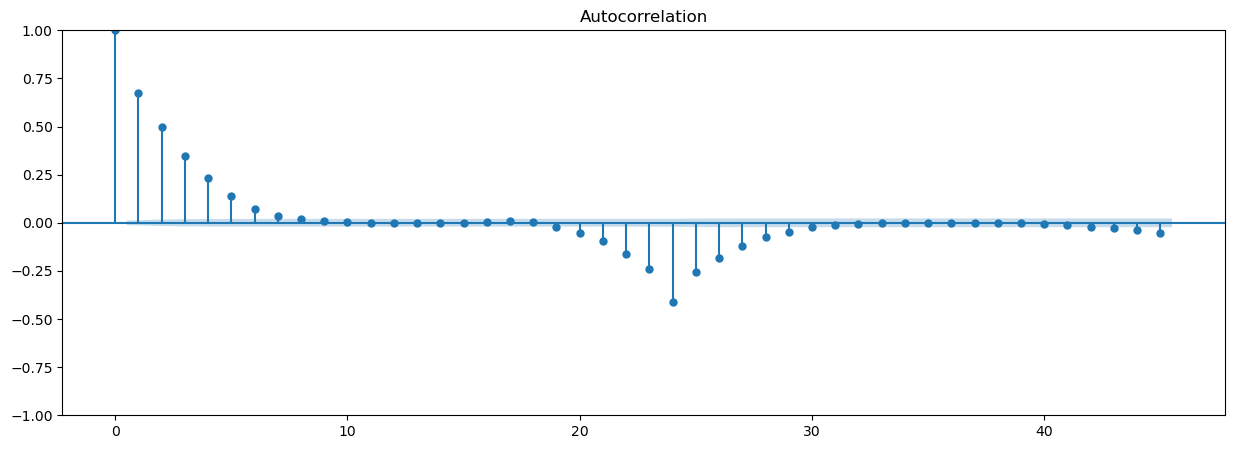

<Figure size 1500x500 with 0 Axes>

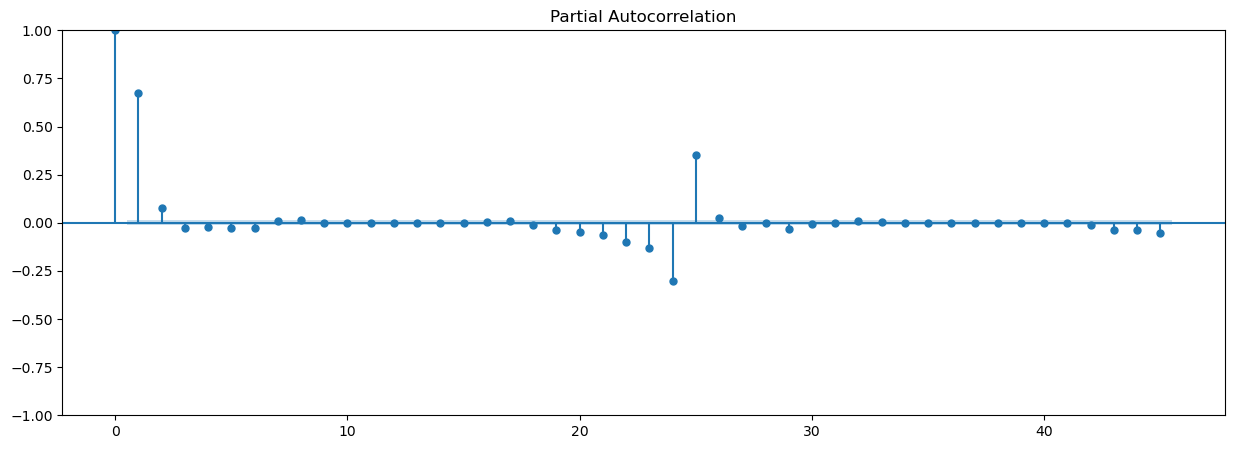

In [10]:
series_stacionary = pd.read_csv('solar_estacionaria.csv',
                    header=0, parse_dates=[0], index_col=[0], usecols=[0, 1], dayfirst=True, 
                    squeeze=True)

plt.figure(); tsaplots.plot_acf(series_stacionary); plt.show()
plt.figure(); tsaplots.plot_pacf(series_stacionary); plt.show()

<div class="qst">

* A la vista de los datos de ACF y PACF obtenidos en el análisis, ¿qué modelo (AR, MA o ARMA) cuadra mejor?

* ¿Qué valores de p y q tienen sentido para una primera prueba?  

</div>

In [11]:
#DEFINICIÓN DEL MODELO
p = 2
q = 0

In [12]:
n_hours=24
mod = SARIMAX_train(solar, (p, 0, q), n_tr+n_va, period=n_hours)
print(mod.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55317D+00    |proj g|=  2.71339D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      3      1     0     0   1.318D-05   5.553D+00
  F =   5.5531696993062614     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                26304
Model:               SARIMAX(2, 0, 0

<div class="qst">

* A la vista del modelo construido, ¿qué retraso es más importante, cuál es el que más informaicón aporta al modelo?

</div>

Para analizar los resultados del entrenamiento, una buena idea suele ser analizar los **residuos**.

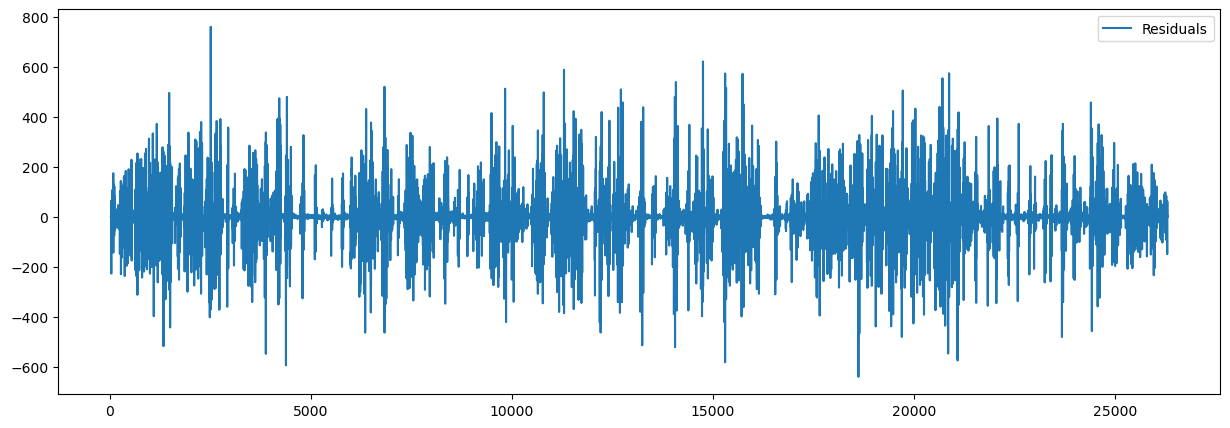

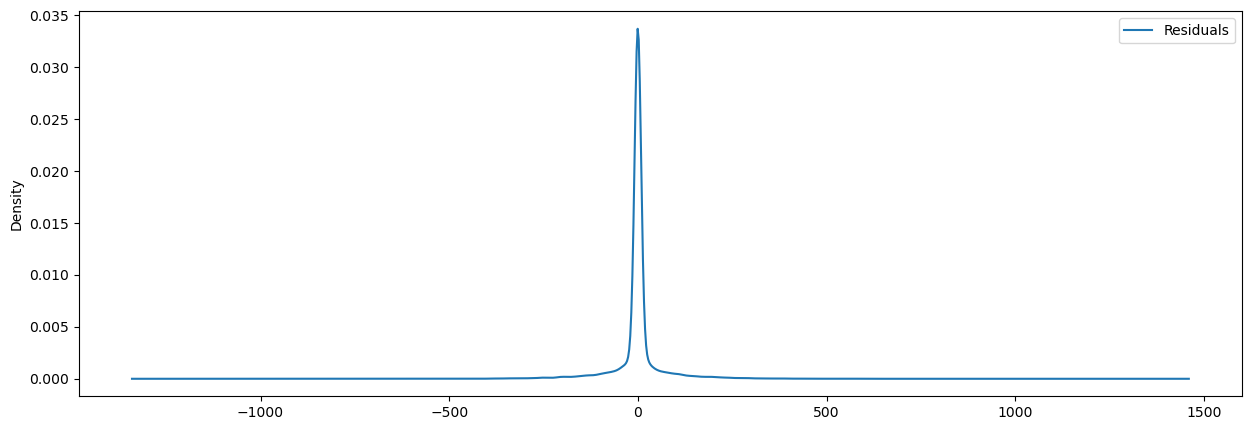

In [13]:
residuals = pd.DataFrame(mod.resid, columns=['Residuals'])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()

In [14]:
residuals.describe()

,Residuals
count,26280.000000
mean,-0.001710
std,63.758934
min,-640.449615
25%,-1.039469
50%,0.000000
75%,0.464281
max,759.828697


<div class="qst">

* ¿Qué nos están diciendo estos residuos? ¿Parecen valores sensatos?

</div>

## Predicción

Definamos a continuación una función que nos permita predecir a distintos horizontes.

In [15]:
"""
SARIMAX_PREDICT
This function predict using a SARIMAX model previously defined.

Parameters
----------
model : previous trained model

s : array_like
    The complete temporal series (joined in one array or dataframe trainning, 
    validation and test sets).

start : integer
        Index where to start predicting.

end : integer
       Index where to end the prediction.
        
horizon : integer
          Horizon for the prediction (0 by default).

period : integer
         Period to de-compute the differentiated series (0 by default). 
"""
def SARIMAX_predict(model, s, start, end, horizon=0, period=0):
    if horizon == 0:
        pred = model.predict(start=start, end=end - 1, dynamic=False)
    else:
        pred = []
        for i in range(start, end):
            print('\r\tComputing... (%5d / %5d)' % (i, end), end='')
            pred.append(model.predict(start=i-horizon, end=i, dynamic=True)[horizon])
        pred = np.array(pred)
        print('\r%50s\r' % ' ', end='')
    if (period != 0):
        return pred + s[start - period:end - period].to_numpy()
    else:
        return pred

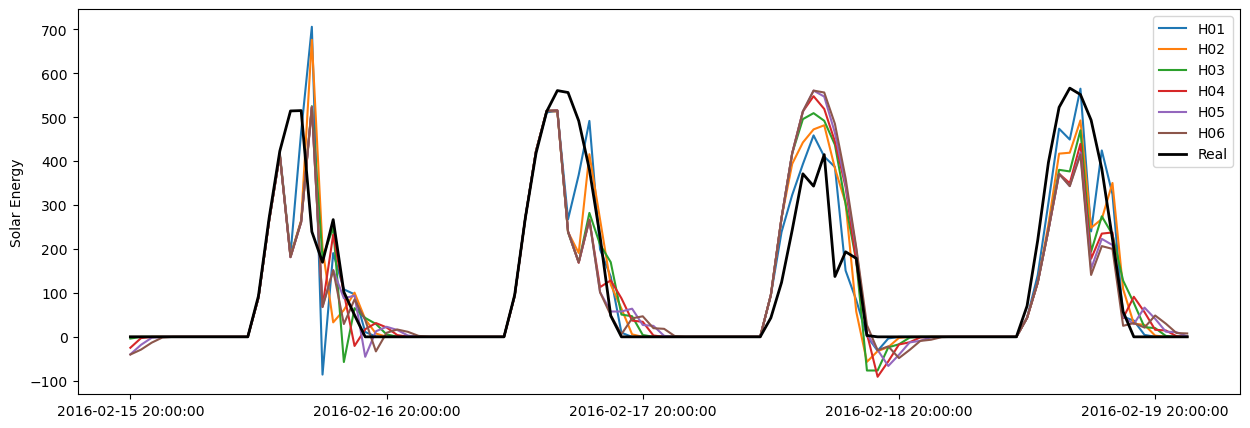

In [16]:
n_horizon=6
n_hours=24

start=n_tr + n_va
end=n_tr + n_va + n_te

for h in range(n_horizon):
    file = '%s/pred0_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, solar, start, end, h, 
                               period=n_hours)
        np.save(file, pred)
    plt.plot(pred[1100:1200], label='H%02d' % (h + 1))
    
#While predicting we plot the first 100 points as an example
y = solar[start+1100:start+1200]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=n_hours)
plt.xticks(xticks, x[xticks])
plt.ylabel("Solar Energy")
plt.legend()
plt.show()

<div class="qst">

* Observando la gráfica obtenida, ¿qué conclusiones podemos extraer?  

</div>

## Evaluación

Para conocer la bondad de la predicción realizada, por un lado podemos pintar los datos predichos frente a los reales (estamos ante un escenario de pruebas) y ver si las dos series se parecen, como hemos hecho en el apartado anterior.

Por otro lado, siempre viene bien una medida cuantitativa que nos permita comparar de forma objetiva el resultado con el obtenido con otros modelos. Aunque esta medida dependerá del problema a resolver y de los objetivos fijados, una de las medidas típicas es el error cuadrático medio. En el contexto de las energía renovables también es muy utilizado el error absoluto medio, por ser el utilizado en los mercados de energía.

Además, el problema al que nos enfrentamos tiene como particularidad una estacionalidad diaria, lo que nos permite realizar un análisis por hora que puede facilitarnos mucha información.

In [17]:
"""
ERRORS_BY_HOUR
This function computes the errors (MAE or MSE), first for the whole test dataset, 
and then per hour separetely.

Parameters
----------
true : array_like
    The real temporal series during a particular testing period. 

pred : array_like
    The predicted temporal series during a particular testing period. 

MAE : boolean, True by default
      True for computing mean_absolute_error, False for computing mean_squared_error

"""
def errors_by_hour(true, pred, MAE=True):
    ind = true.index
    ind_hour = ind.hour
    min_hour = ind_hour.min()
    max_hour = ind_hour.max()
    
    if MAE==True:
        maes = [mean_absolute_error(true, pred)]
        for hour in range(min_hour, max_hour + 1):
            maes.append(mean_absolute_error(true[ind_hour == hour].to_numpy(), 
                                            pred[ind_hour == hour]))
        return np.arange(min_hour, max_hour + 1), maes
    else: 
        mses = [mean_squared_error(true, pred)]
        for hour in range(min_hour, max_hour + 1):
            mses.append(mean_squared_error(true[ind_hour == hour].to_numpy(), 
                                           pred[ind_hour == hour]))
        return np.arange(min_hour, max_hour + 1), mses

In [18]:
maes_h=[]
n_horizon=6
for h in range(n_horizon):
    file = '%s/pred0_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    hours, maes = errors_by_hour(solar[start:end], pred, MAE=True)
    maes_h.append(maes)

Podemos pintar los errores por hora a horizonte 0.

In [19]:
horizon=0
print('Total MAE: %.2f' % (maes_h[horizon][0]))
for h in range(24):
    print('MAE Hora %02d: %.2e' % (h, maes_h[horizon][h+1]))

Total MAE: 25.78
MAE Hora 00: 0.00e+00
MAE Hora 01: 0.00e+00
MAE Hora 02: 0.00e+00
MAE Hora 03: 0.00e+00
MAE Hora 04: 0.00e+00
MAE Hora 05: 1.22e-02
MAE Hora 06: 4.02e+00
MAE Hora 07: 1.35e+01
MAE Hora 08: 3.18e+01
MAE Hora 09: 5.01e+01
MAE Hora 10: 6.40e+01
MAE Hora 11: 7.37e+01
MAE Hora 12: 6.69e+01
MAE Hora 13: 7.62e+01
MAE Hora 14: 7.80e+01
MAE Hora 15: 5.77e+01
MAE Hora 16: 4.87e+01
MAE Hora 17: 3.28e+01
MAE Hora 18: 1.47e+01
MAE Hora 19: 6.01e+00
MAE Hora 20: 7.55e-01
MAE Hora 21: 2.66e-02
MAE Hora 22: 2.38e-18
MAE Hora 23: 1.15e-19


<div class="qst">

* ¿Qué te dicen estos errores por hora? ¿Crees que son sensatos?
* ¿Y si evaluamos el horizonte 5? ¿Sacamos las mismas conclusiones? 

</div>

Podemos calcular los errores por horizonte, y compararlos con una gráfica.

MAE Total H01: 25.78
MAE Total H02: 31.29
MAE Total H03: 34.16
MAE Total H04: 35.33
MAE Total H05: 35.72
MAE Total H06: 35.84


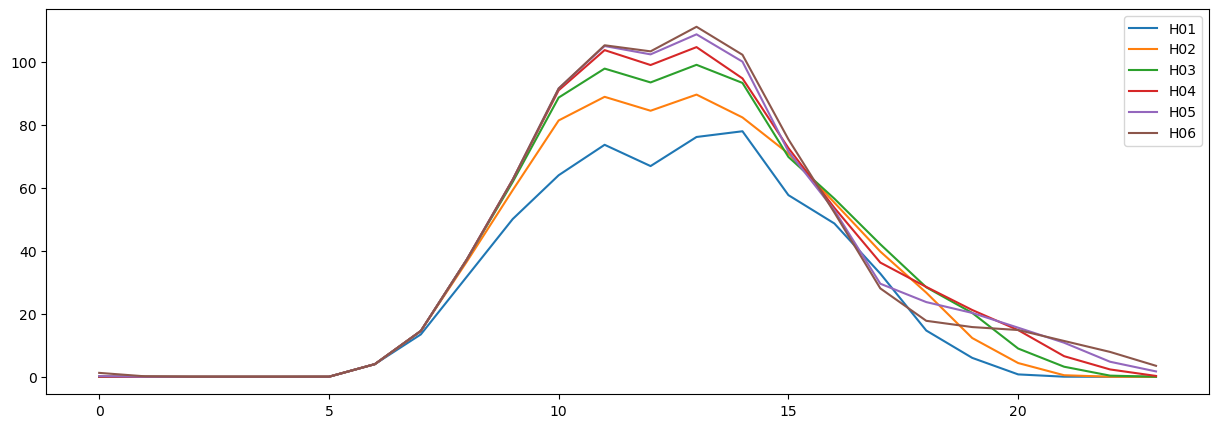

In [20]:
n_horizon=6

maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(hours, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

<div class="qst">

* ¿Qué se aprecia en la gráfica anterior?  

</div>

## Búsqueda de hiperparámetros

Una parte importante a la hora de realizar un modelo es validar el mismo y elegir así los valores de los hiperparámetros. En ST no podemos utilizar CV porque necesitamos mantener la ordenación temporal. Al proceso de validación en ST se le denomina **backtesting**, y vamos a utilizar para este caso un único conjunto de validación realizando una búsqueda en rejilla de los mejores valores para nuestros hiperparámetros.

El siguiente código recoge en una función la metodología de validación para los hiperparámetros p y q que definen el orden de un modelo autorregresivo simpe. Nótese que al estar pegado al problema de las energías renovables, se optimizan los valores de los hiperparámetros en términos de MAE. 

In [21]:
"""
VALIDATE
It obtains the optimal hyperparameters, based on the MAE as score function

Parameters
----------
horizon : integer
          Horizon for the prediction.

s : array_like
    The complete temporal series (joined in one array or dataframe trainning, 
    validation and test sets).

n_tr : integer
       The size of the training set to be considered.

n_va : integer
       The size of the validation set to be considered.

period : integer
         Period to de-compute the differentiated series (0 by default). 
"""
def validate(horizon, s, n_tr, n_va, period=0):
    vec_p = np.arange(10)
    vec_q = np.arange(10)
    
    best_e = np.inf
    
    true = s[n_tr:n_tr + n_va].to_numpy()
    for p in vec_p:
        for q in vec_q:
            try:
                model = SARIMAX_train(s, (p, 0, q), n_tr, period=period)
                pred = SARIMAX_predict(model, s, n_tr, n_tr + n_va, horizon, period=period)
                e = mean_absolute_error(true, pred)
            except Exception as exc:
                e = np.inf
            if (e < best_e):
                best_e = e
                best_p = p
                best_q = q
            
            print('%d %d => %.4f' % (p, q, e))
    
    order = (best_p, 0, best_q)
    print('\tBest:', order)

    return order

### Validation

Vamos a validar el modelo para horizonte 0 y utilizaremos estos valores para el resto de horizontes. Se pueden obtener distintos hiperparámetros para cada horizonte a considerar, mejorando así el resultado obtenido (aunque a costa de mucho esfuerzo computacional).

In [ ]:
file = '%s/order.npy' % (output_folder)
if isfile(file):
    order = np.load(file)
    print(order)
else:
    order = validate(0, solar, n_tr, n_va - 6, period=n_hours)
    np.save(file, order)

<div class="qst">

* ¿Qué modelo ha elegido?  

</div>

### Train y Test

Una vez tenemos los mejores hiperparámetros, debemos volver a entrenar el modelos con los conjuntos de entrenamiento y validación (para contar con la información más reciente) y predecimos sobre el conjunto de test.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55658D+00    |proj g|=  2.69050D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   1.391D-05   5.557D+00
  F =   5.5565839056976998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


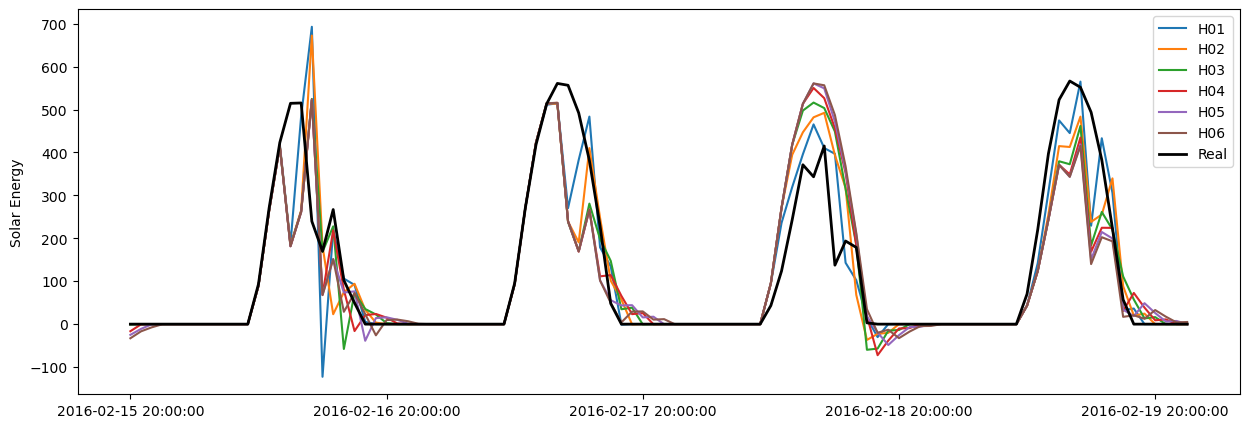

In [35]:
maes_h = []
n_horizon=6
n_hours=24

start=n_tr + n_va
end=n_tr + n_va + n_te

#Reentrenamos con todo el conjunto de entrenamiento y validación 
mod = SARIMAX_train(solar, order, n_tr + n_va, period=n_hours)

for h in range(n_horizon):
    file = '%s/predARval_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, solar, start, end, h, period=n_hours)
        np.save(file, pred)
    plt.plot(pred[1100:1200], label='H%02d' % (h + 1))
    hours, maes = errors_by_hour(solar[start:end], pred, MAE=True)
    maes_h.append(maes)
    
y = solar[start+1100:start+1200]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=n_hours)
plt.xticks(xticks, x[xticks])
plt.ylabel("Solar Energy")
plt.legend()
plt.show()

MAE Total H01: 25.59
MAE Total H02: 30.93
MAE Total H03: 33.56
MAE Total H04: 34.50
MAE Total H05: 34.79
MAE Total H06: 34.79


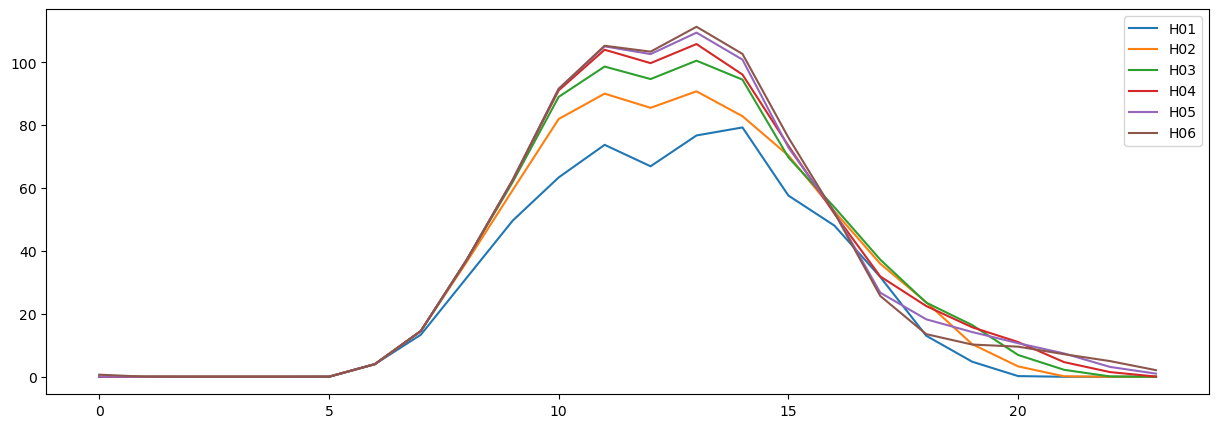

In [36]:
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(hours, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

<div class="qst">

* ¿Cómo compara esta gráfica frente a la del modelo anterior?  

</div>

# ARIMA

Pasamos a un modelo más complejo ahora, un modelo **ARIMA** que es capaz de modelar las **tendencias**. Probamos primero con un modelo con los mejores hiperparámetros anteriores, pero "activando" la `d` para eliminar tendencias.

**NOTA:** Es importante tener en cuenta que para obtener los mejores modelos debemos realizar una fase de validación SIEMPRE.

In [37]:
n_hours=24
p=1
d=1
q=0
mod = SARIMAX_train(solar,(p, d, q), n_tr+n_va, period=n_hours)
print(mod.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.61827D+00    |proj g|=  1.45423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   4.771D-06   5.618D+00
  F =   5.6182654819291455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                26304
Model:               SARIMAX(1, 1, 0)   Log Likelihood             -148208.093
Date:                Sat, 10 Dec 2022   AIC                         296420.186
Time:                        17:38:55   BIC                         296436.541
Sample:                             0   HQIC                        296425.467
                              - 26304                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2329      0.003    -82.828      0.000      -0.238      -0.227
sigma2      4509.1580     14.714    306.454      0.000    4480.319    4537.997
Ljung-Box (L1) (Q):                   7.04   Jarque-

<div class="qst">

* ¿Qué coeficiente está cogiendo ahora para el retraso anterior? ¿Qué significa esto?
    
* A la vista del modelo construido, ¿crees que mejorará los resultados anteriores?

</div>

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.61827D+00    |proj g|=  1.45423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   4.771D-06   5.618D+00
  F =   5.6182654819291455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


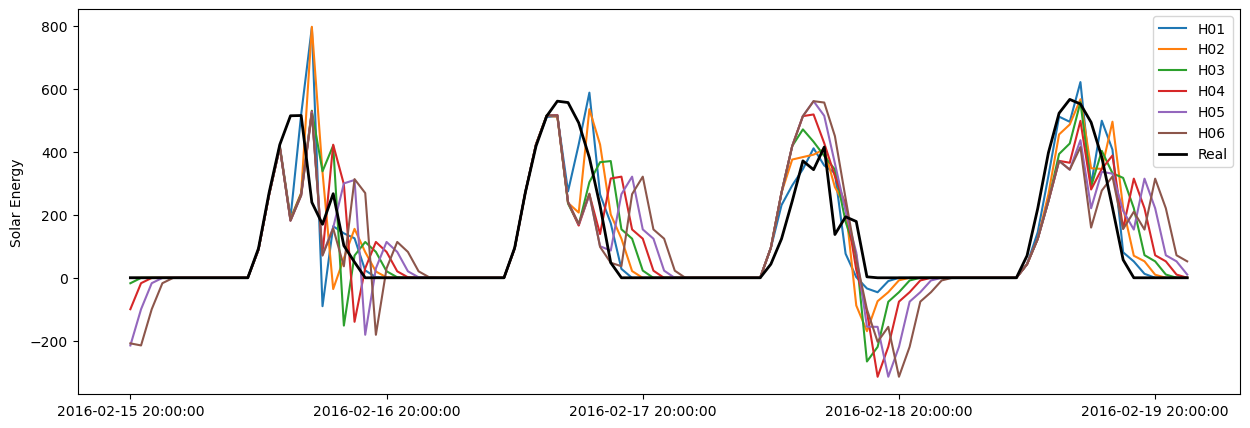

In [38]:
maes_h = []
n_horizon=6
n_hours=24

start=n_tr + n_va
end=n_tr + n_va + n_te

#Reentrenamos con todo el conjunto de entrenamiento y validación 
mod = SARIMAX_train(solar, (p, d, q), n_tr + n_va, period=n_hours)

for h in range(n_horizon):
    file = '%s/predARIMA_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, solar, start, end, h, period=n_hours)
        np.save(file, pred)        
    plt.plot(pred[1100:1200], label='H%02d' % (h + 1))
    hours, maes = errors_by_hour(solar[start:end], pred, MAE=True)
    maes_h.append(maes)
    
y = solar[start+1100:start+1200]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=n_hours)
plt.xticks(xticks, x[xticks])
plt.ylabel("Solar Energy")
plt.legend()
plt.show()

MAE Total H01: 28.25
MAE Total H02: 37.27
MAE Total H03: 44.11
MAE Total H04: 49.29
MAE Total H05: 54.02
MAE Total H06: 57.39


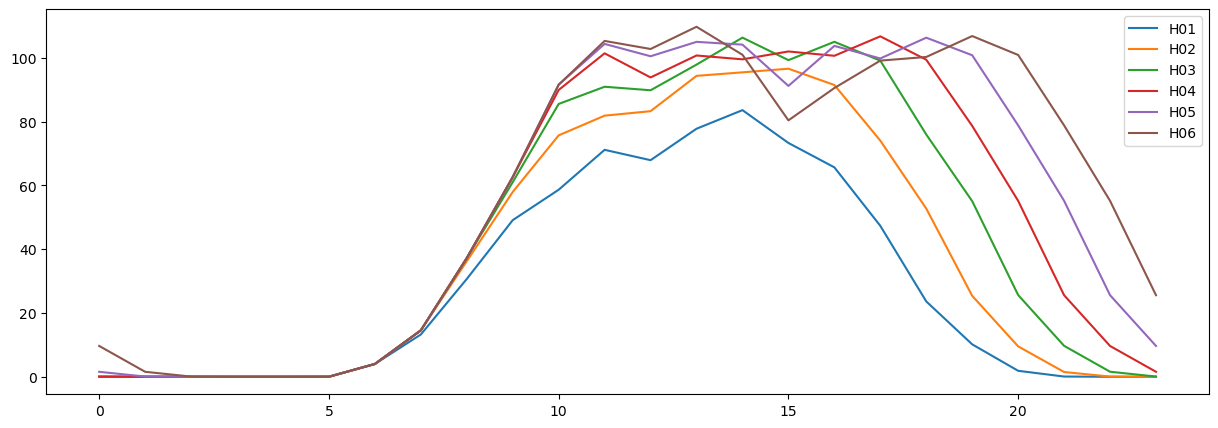

In [39]:
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(hours, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

<div class="qst">

* ¿Qué se aprecia en este modelo?
    
* ¿A qué crees que pueden deberse estas diferencias?

</div>

# SARIMA

El siguiente paso es aplicar un modelo más complicado que modela también la estacionalidad presente en los datos. Este es el modelo SARIMA.

Es importante fijarse en que el objetivo de este modelo es modelar la estacionalidad a la vez que los datos, por lo que NO debemos aplicar diferencias y es importante que el period sea 0.

Al igual que en el caso de ARIMA, vamos a asumir como mejores hiperparámetros, los mejores encontrados hasta el momento, es decir `p=1`, `d=0`, `q=0`. Pero ahora debemos definir también los parámetros de la parte estacional. Como no sabemos cuáles serán los mejores, vamos a hiperparametrizarlos, modificando ligeramente la función de validación a estos hiperparámetros. Vamos a probar indicando que hay una estacionbalidad diaria, y por tanto nuestro periodo es de 24 horas (`per=24`).

In [40]:
"""
VALIDATE_SEASONAL
It obtains the optimal sesonal hyperparameters, based on the MAE as score function

Parameters
----------
horizon : integer
          Horizon for the prediction.

s : array_like
    The complete temporal series (joined in one array or dataframe trainning, 
    validation and test sets).

n_tr : integer
       The size of the training set to be considered.

n_va : integer
       The size of the validation set to be considered.

p : integer
    AR order.
    
p : integer
    MA order.
    
d : integer
    differentiating order for ARIMA.
    
per: integer
     period for seasonbal evaluation.
"""
def validate_seasonal(horizon, s, n_tr, n_va, p, d, q, per):
    vec_P = np.arange(3)
    vec_Q = np.arange(2)
    vec_D = np.arange(2)
    
    best_e = np.inf
    
    true = s[n_tr:n_tr + n_va].to_numpy()
    for P in vec_P:
        for Q in vec_Q:
            for D in vec_D:
                try:
                    print("TRAIN %d %d % d" % (P, D, Q))
                    model = SARIMAX_train(s, (p, d, q), n_tr, period=0, seasonal_order=(P,D,Q,per))
                    print("PRED")
                    pred = SARIMAX_predict(model, s, n_tr, n_tr + n_va, horizon, period=0)
                    e = mean_absolute_error(true, pred)
                except Exception as exc:
                    e = np.inf
                if (e < best_e):
                    best_e = e
                    best_P = P
                    best_Q = Q
                    best_D = D
            
                print('%d %d % d => %.4f' % (P, D, Q, e))
    
    seasonal_order = (best_P, best_D, best_Q, per)
    print('\tBest:', seasonal_order)

    return seasonal_order

In [41]:
p=1
d=0
q=0

per=24 #Cada 24 datos es un ciclo

In [ ]:
file = '%s/sarima_order.npy' % (output_folder)
if isfile(file):
    seasonal_order = np.load(file)
    print(seasonal_order)
else:
    seasonal_order = validate_seasonal(0, solar, n_tr, n_va - 6, p, d, q, per)
    np.save(file, seasonal_order)

In [ ]:
maes_h = []
n_horizon=6

start=n_tr + n_va
end=n_tr + n_va + n_te

#Reentrenamos con todo el conjunto de entrenamiento y validación 
mod = SARIMAX_train(solar, (p, d, q), n_tr + n_va, period=0, seasonal_order=seasonal_order)

for h in range(n_horizon):
    file = '%s/predSARIMA_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, solar, start, end, h, period=0)
        np.save(file, pred)
    plt.plot(pred[1100:1200], label='H%02d' % (h + 1))
    hours, maes = errors_by_hour(solar[start:end], pred, MAE=True)
    maes_h.append(maes)
    
y = solar[start+1100:start+1200]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=24)
plt.xticks(xticks, x[xticks])
plt.ylabel("Solar Energy")
plt.legend()
plt.show()

In [ ]:
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(hours, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

<div class="qst">

* ¿Qué se aprecia en este modelo?
    
* ¿Qué diferencias se pueden ver frente a modelos anteriores?

</div>

# SARIMAX (variables exógenas)

Probamos con el mejor modelo anterior. Cogemos SARIMA, aunque solo es mejor en los primeros horizontes.

Sobre este modelo vamos a añadir una variable exógena: la variable Gb(i) que representa la radiación directa (en W/m2).

El resto de variables presentes en el fichero son:

* Gd(i): radiación difusa (W/m2)
* Gr(i): radiación reflejada (W/m2)
* H_sun: altura del sol (degree)
* T2m: temperatura del aire a 2m (degree Celsius)
* WS10m: velocidad del viento a 10m (m/s)

In [ ]:
solar = pd.read_csv('solar.csv',
                    header=0, parse_dates=[0], index_col=[0], usecols=[0, 1, 2
                                                                      ], 
                    dayfirst=True, squeeze=True)

In [ ]:
solar.head(20)

<div class="qst">

* A primera vista, ¿qué pinta tienen los datos? ¿Crees que pueden ser de ayuda?

</div>

In [ ]:
maes_h = []
n_horizon=6

#Reutilizamos los valores d elos mejores hiperparámetros obtenidos hasta el momento
p=1
d=0
q=0
seasonal_order=(1,1,1,24)
  

#Reentrenamos con todo el conjunto de entrenamiento y validación 
mod = SARIMAX_train(solar.loc[:,'P'], (p, d, q), n_tr + n_va, period=0, seasonal_order=seasonal_order, 
                    exog=solar.loc[:,'Gb(i)'])

for h in range(n_horizon):
    file = '%s/predSARIMAX_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)        
    else:
        pred = SARIMAX_predict(mod, solar.loc[:,'P'], start, end, h, period=0)
        np.save(file, pred)
    
    plt.plot(pred[1100:1200], label='H%02d' % (h + 1))
    hours, maes = errors_by_hour(solar.loc[:,'P'][start:end], pred, MAE=True)
    maes_h.append(maes)
    
y = solar.loc[:,'P'][start+1100:start+1200]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=24)
plt.xticks(xticks, x[xticks])
plt.ylabel("Solar Energy")
plt.legend()
plt.show()

In [ ]:
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(hours, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

<div class="qst">

* ¿Como compara este modelo frente  a los anteriores?
    
* ¿Crees que es buena idea utilizar variables exógenas? ¿En este problema o en general? ¿Merecería la pena probar el resto de variables exógenas disponibles?

</div>

# LSTM

Vamos a hacer por último una pequeña prueba con una red LSTM, estado del arte en predicción de series temporales.

Para esto, al corresponderse a un paradigma completamente diferente, necesitaremos nuevos paquetes específicos. Además, estos modelos hay que montarlos en keras.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.utils import set_random_seed

2022-12-09 22:27:43.280591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 22:27:44.840209: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-12-09 22:27:44.841071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-12-09 22:27:44.841080: W tensorflow/com

Vamos a definir primero la red. Keras permite añadir capas cuyas neuronas son celdas **LSTM**.

Vamos a definir una arquitectura sencilla, regularizada con un dropout. Al final debemos colocar una capa `Dense` que nos genere la salida de la regresión.

Esta arquitectura se puede modificar, añadiendo más unidades y más capas, incluso de otros tipos de redes neuronales.

In [ ]:
def create_rnn():
    set_random_seed(123)

    rnn = Sequential()
    rnn.add(LSTM(200, input_shape=(24, 1)))
    rnn.add(Dropout(0.4, input_shape=(1,)))
    rnn.add(Dense(1))
    rnn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])
    return rnn

Para este tipo de modelos suele ser importante escalar los datos. 

Además debemos montar conjuntos diferentes para predecir a distintos horizontes, separando las variables de entrada de las salidas (que son los mismos datos, pero desplazados).

In [ ]:
def create_dataset(s, h=0, batch_size=32):
    y = s[h+1:]
    x = s[:-(h+1)]
    
    x = MinMaxScaler().fit_transform(np.array(x).reshape(-1, 1))
    
    x, y = x.reshape(-1, 1), y.to_numpy().reshape(-1, 1)
    dataset = timeseries_dataset_from_array(x, y, sequence_length=24, batch_size=batch_size)

    dataset_tr = dataset.take(int((n_tr + n_va) / batch_size))
    dataset_te = dataset.skip(int((n_tr + n_va) / batch_size))
    y_te = np.concatenate([batch[1].numpy() for batch in dataset_te])
    
    return dataset_tr, dataset_te, y_te

Para nuestro ejemplo, volvemos a cargar los datos sin variables exógenas.

In [ ]:
solar = pd.read_csv('solar.csv',
                    header=0, parse_dates=[0], index_col=[0], usecols=[0, 1], dayfirst=True, 
                    squeeze=True)

Vamos a predecir de nuevo para los distintos horizontes.

Aquí también será importante entrenar la red durante un número de épocas suficientes para que la red aprenda. En este caso vamos a dejar muchas épocas para el primer modelo (horizonte 1), y luego vamos a reutilizar lo aprendido por el modelo haciendo uso del *transfer learning*, de forma que con un *fine tunning* de 10 épocas adaptamos lo aprendido a cada cambio de horizonte. 

Epoch 1/100
547/547 [==============================] - 8s 12ms/step - loss: 64201.2227 - mean_absolute_error: 168.5305
Epoch 2/100
547/547 [==============================] - 7s 12ms/step - loss: 55760.3672 - mean_absolute_error: 179.8072
Epoch 3/100
547/547 [==============================] - 7s 12ms/step - loss: 53664.5586 - mean_absolute_error: 187.6024
Epoch 4/100
547/547 [==============================] - 7s 12ms/step - loss: 53149.4297 - mean_absolute_error: 191.4817
Epoch 5/100
547/547 [==============================] - 7s 12ms/step - loss: 53078.1406 - mean_absolute_error: 193.3790
Epoch 6/100
547/547 [==============================] - 7s 12ms/step - loss: 53182.8320 - mean_absolute_error: 194.3204
Epoch 7/100
547/547 [==============================] - 6s 12ms/step - loss: 53170.9922 - mean_absolute_error: 193.9850
Epoch 8/100
547/547 [==============================] - 6s 12ms/step - loss: 53418.9570 - mean_absolute_error: 184.0019
Epoch 9/100
547/547 [===========================

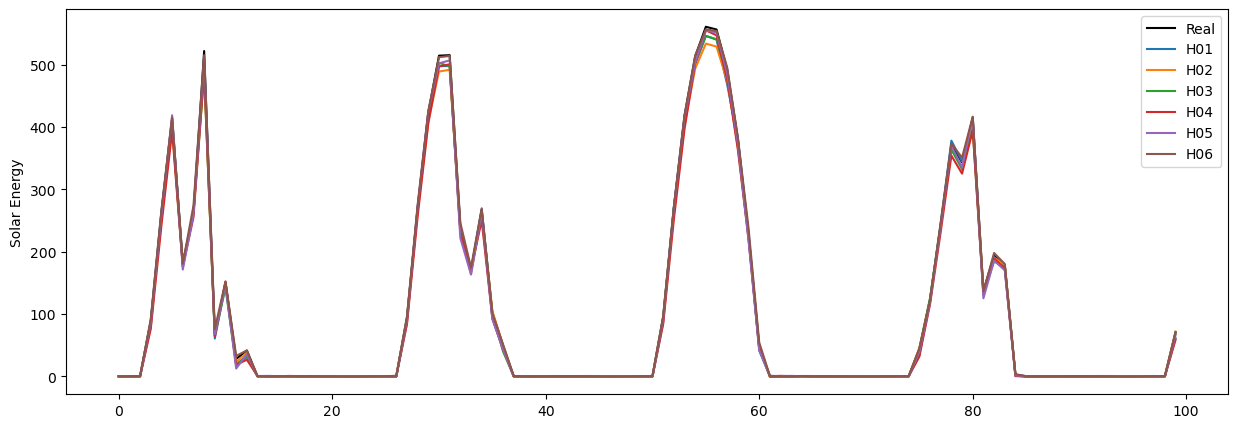

In [ ]:
rnn = create_rnn()
mae_lstm=[]
epochs=[100, 10, 10, 10, 10, 10]

for h in range(6):

    dataset_tr, dataset_te, y_te = create_dataset(solar, h=h)
    
    file = '%s/LSTM/predLSTM_H%02d.npy' % (output_folder, h)
    if isfile(file):
        preds_rnn = np.load(file)
    else:
        history_rnn = rnn.fit(dataset_tr, epochs=epochs[h], verbose=1)
        preds_rnn = rnn.predict(dataset_te, verbose=0)
    
        np.save(file, preds_rnn)
        
    if (h == 0):
        plt.plot(y_te[1100:1200], "k", label='Real')
    plt.plot(preds_rnn[1100-h:1200-h], label='H%02d' % (h+1))
    mae_lstm.append(mean_absolute_error(y_te, preds_rnn))

plt.ylabel("Solar Energy")
plt.legend()
plt.show()

Pintamos por último los errores obtenidos por horizonte, aunque en este caso no se han calculado por hora.

Observa que la gráfica es un poco diferente y pinta el error total para cada horizonte.

MAE Total H01: 4.81
MAE Total H02: 6.33
MAE Total H03: 5.40
MAE Total H04: 6.53
MAE Total H05: 4.31
MAE Total H06: 3.46


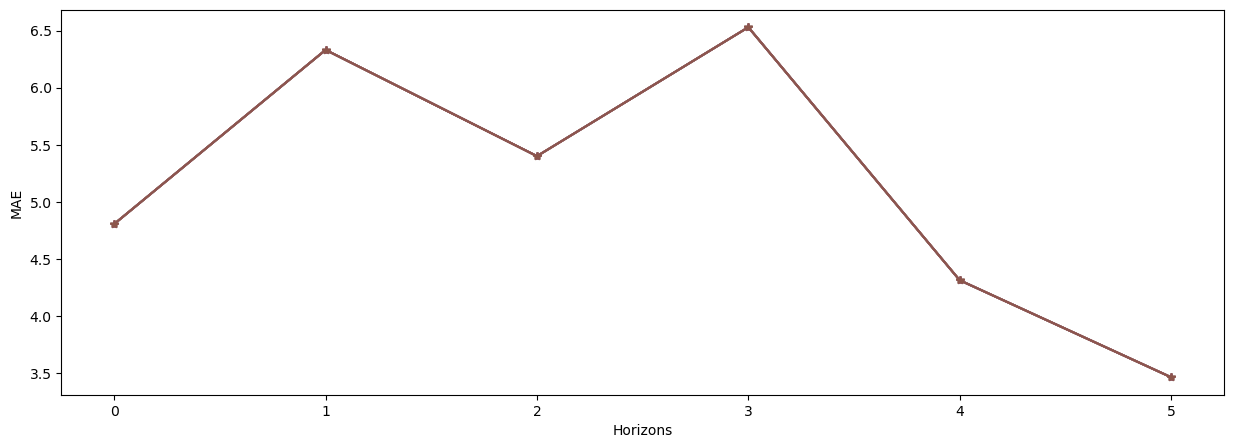

In [ ]:
for h in range(6):
    plt.plot(mae_lstm, '*-')
    print('MAE Total H%02d: %.2f' % (h + 1, mae_lstm[h]))
plt.xlabel("Horizons")
plt.ylabel("MAE")
plt.show()

<div class="qst">

* Observando esta gráfica y la obtenida comparando los datos reales frente a las predicciones, ¿qué conclusiones obtienes?

</div>